In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'experiments-average/'

### Needed Constants and Variables

In [3]:
SURVEY_ZONE_MAPPING = {'30': (2, 2, 0), '22': (3, 1, 2), '2c': (2, 0, 0), '28': (2, 2, 1), '25': (3, 2, 1), '26': (3, 1, 1), '27': (3, 0, 1), '20': (2, 2, 2), '21': (3, 2, 2), '1e': (3, 1, 2), '23': (3, 0, 2), '24': (2, 0, 1), '29': (3, 2, 1), '1a': (3, 1, 3), '0': (1, 0, 3), '3': (3, 1, 0), '2': (3, 2, 0), '5': (1, 0, 0), '1d': (3, 2, 2), '7': (2, 1, 1), '1f': (3, 0, 2), '9': (3, 1, 1), '8': (3, 2, 1), '3a': (3, 1, 3), '1c': (2, 0, 2), '4': (3, 0, 0), 'a': (3, 0, 1), '6': (1, 0, 1), '39': (3, 2, 3), '12': (1, 0, 2), '3b': (3, 0, 3), '1b': (3, 0, 3), 'b': (1, 0, 2), '13': (1, 0, 2), 'd': (3, 2, 2), '11': (1, 0, 3), '10': (1, 0, 3), 'c': (2, 1, 2), '38': (2, 0, 3), '15': (1, 0, 1), '14': (1, 0, 1), '17': (1, 0, 0), 'f': (3, 0, 2), '19': (3, 2, 3), '32': (3, 1, 0), '31': (3, 2, 0), '16': (1, 0, 0), '37': (3, 0, 3), '36': (3, 1, 3), '35': (3, 2, 3), '34': (2, 1, 3), '2d': (3, 2, 0), '2e': (3, 1, 0), '2f': (3, 0, 0), '1': (2, 1, 0), '2a': (3, 1, 1), '2b': (3, 0, 1), '18': (2, 2, 3), '33': (3, 0, 0), 'e': (3, 1, 2)}

In [54]:
_demands = [
    450,
    900,
    (450, 900),
    (900, 1800)
]

_weights = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.5, 0.5, 0),
    (0, 0.5, 0.5),
    (0.5, 0, 0.5),
    (0.33, 0.33, 0.33),
    (0, 0, 0)
]

_model_type = {
    (1, 0, 0): 'Delay priority',
    (0, 1, 0): 'Throughput priority',
    (0, 0, 1): 'Flow priority',
    (0.5, 0.5, 0): 'Delay-Throughput priority',
    (0, 0.5, 0.5): 'Throughput-Flow priority',
    (0.5, 0, 0.5): 'Delay-Flow priority',
    (0.33, 0.33, 0.33): 'Equal priority',
    (0, 0, 0): 'Parent model',
}

_model_type_cols = [
    'Delay priority',
    'Throughput priority',
    'Flow priority',
    'Delay-Throughput priority',
    'Throughput-Flow priority',
    'Delay-Flow priority',
    'Equal priority',
    'Parent model'
]

In [5]:
_entrance_cols = [(2, 0, 0),     (2, 0, 1),
           (2, 0, 2),     (2, 0, 3),     (2, 1, 0),     (2, 1, 1),
           (2, 1, 2),     (2, 1, 3),     (2, 2, 0),     (2, 2, 1),
           (2, 2, 2),     (2, 2, 3),     (3, 0, 0),     (3, 0, 1),
           (3, 0, 2),     (3, 0, 3),     (3, 1, 0),     (3, 1, 1),
           (3, 1, 2),     (3, 1, 3),     (3, 2, 0),     (3, 2, 1),
           (3, 2, 2),     (3, 2, 3)]

_exit_cols = [(1,0,0), (1,0,1), (1,0,2), (1,0,3)]

In [6]:
PRE_MOVEMENT_APRROACH = {
    'north': [(3,0,0), (3,1,0), (3,2,0)],
    'east': [(3,0,1), (3,1,1), (3,2,1)],
    'south': [(3,0,2), (3,1,2), (3,2,2)],
    'west': [(3,0,3), (3,1,3), (3,2,3)],
}

MOVEMENT_APRROACH = {
    'north': [(2,0,0), (2,1,0), (2,2,0)],
    'east': [(2,0,1), (2,1,1), (2,2,1)],
    'south': [(2,0,2), (2,1,2), (2,2,2)],
    'west': [(2,0,3), (2,1,3), (2,2,3)],
}

MOVEMENT_EXITS_RENAME = {
    (1,0,0): 'north',
    (1,0,1): 'east',
    (1,0,2): 'south',
    (1,0,3): 'west',
}

MOVEMENTS = ['north', 'east', 'south', 'west']

In [7]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 1
}

---

## Loading dataframes

In [8]:
# Results of the MILP solver only (Expected)

df_milp = pd.read_pickle(DF_PATH + 'ave_milp_results.pkl')
df_milp['model_type'] = pd.Categorical(df_milp['model_type'], _model_type_cols)

df_milp.head()

,demand,new_model,alpha,beta,gamma,model_type,epoch,runtime,delay,throughput,objective_value
0,450,False,0.0,0.0,0.0,Parent model,0,370.309661,2313.000000,79.500000,79.500000
1,450,False,0.0,0.0,0.0,Parent model,1,79.655836,6809.105485,127.363221,127.363221
2,450,False,0.0,0.0,0.0,Parent model,2,76.947723,9181.654008,128.917018,128.917018
3,450,False,0.0,0.0,0.0,Parent model,3,81.051107,12968.939522,129.139241,129.139241
4,450,False,0.0,0.0,1.0,Flow priority,0,573.475265,3265.265823,52.278481,-2055.801688


In [9]:
# Results of the LocalSim simulator only (Actual, Aggregate)
# Delay, Throughput

df_ave_delay = pd.read_pickle(DF_PATH + 'agg_ave_delays.pkl')
df_total_delay = pd.read_pickle(DF_PATH + 'agg_total_delays.pkl')
df_total_thru = pd.read_pickle(DF_PATH + 'agg_total_thrus.pkl')

df_ave_delay['model_type'] = pd.Categorical(df_ave_delay['model_type'], _model_type_cols)
df_total_delay['model_type'] = pd.Categorical(df_total_delay['model_type'], _model_type_cols)
df_total_thru['model_type'] = pd.Categorical(df_total_thru['model_type'], _model_type_cols)

df_total_thru.head()

level_1,demand,new_model,alpha,beta,gamma,model_type,"(1, 0, 0)","(1, 0, 1)","(1, 0, 2)","(1, 0, 3)"
0,450,False,0.00,0.00,0.00,Parent model,1104.333333,1028.555556,1048.888889,999.888889
1,450,True,0.00,0.00,1.00,Flow priority,1061.666667,986.888889,1050.555556,1092.444444
2,450,True,0.00,0.50,0.50,Throughput-Flow priority,1076.333333,1045.777778,1052.888889,1049.222222
3,450,True,0.00,1.00,0.00,Throughput priority,996.555556,1008.333333,1023.555556,1072.888889
4,450,True,0.33,0.33,0.33,Equal priority,1054.111111,1075.111111,989.000000,1031.333333


In [58]:
# Results of the LocalSim simulator only (Actual, Aggregate)
# Speed, Travel Time

df_ave_speed = pd.read_pickle(DF_PATH + 'agg_speeds.pkl')
df_ave_traveltime = pd.read_pickle(DF_PATH + 'agg_traveltimes.pkl')

df_ave_speed['model_type'] = pd.Categorical(df_ave_speed['model_type'], _model_type_cols)
df_ave_traveltime['model_type'] = pd.Categorical(df_ave_traveltime['model_type'], _model_type_cols)

df_ave_speed.head()

,approach,movement,demand,new_model,alpha,beta,gamma,model_type,average_speed
0,East,Left,450,False,0.00,0.00,0.00,Parent model,19.882222
1,East,Left,450,True,0.00,0.00,1.00,Flow priority,13.883333
2,East,Left,450,True,0.00,0.50,0.50,Throughput-Flow priority,15.475556
3,East,Left,450,True,0.00,1.00,0.00,Throughput priority,9.461111
4,East,Left,450,True,0.33,0.33,0.33,Equal priority,8.375556


In [77]:
# Comparing computed and measured values (Expected vs Actual)

df_delay_comp = pd.read_pickle(DF_PATH + 'delay_comparison.pkl')
df_thru_comp = pd.read_pickle(DF_PATH + 'throughput_comparison.pkl')

df_delay_comp['model_type'] = pd.Categorical(df_delay_comp['model_type'], _model_type_cols)
df_thru_comp['model_type'] = pd.Categorical(df_thru_comp['model_type'], _model_type_cols)

df_delay_comp.head()

,demand,model_type,expected,actual,epoch
127,450,Delay priority,3069.088608,568.353586,0
126,450,Delay priority,7250.666667,5682.759704,1
125,450,Delay priority,9813.794655,12692.179240,2
124,450,Delay priority,13390.292546,17500.346264,3
123,450,Throughput priority,3500.000000,542.707982,0


---

## Checking average actual delay in the 32 cases

In [80]:
for m in MOVEMENTS:
    df_ave_delay['pre_movement_'+m] = df_ave_delay[PRE_MOVEMENT_APRROACH[m]].sum(axis=1)
    df_ave_delay['movement_'+m] = df_ave_delay[MOVEMENT_APRROACH[m]].mean(axis=1)
    df_ave_delay['delay_'+m] = df_ave_delay['pre_movement_'+m] + df_ave_delay['movement_'+m]

cols = ['demand', 'new_model', 'alpha', 'beta', 'gamma', 'model_type', 'delay_north', 'delay_east', 'delay_south', 'delay_west']
delay_cols = ['delay_north', 'delay_east', 'delay_south', 'delay_west']

df_ave_delay['average_delay'] = df_ave_delay[delay_cols].mean(axis=1)
df_ave_delay['std_delay'] = df_ave_delay[delay_cols].std(axis=1)

### Average delay per vehicle (seconds)

In [81]:
df_ave_delay_table = df_ave_delay.pivot(index='demand', columns='model_type', values='average_delay')[_model_type_cols]
df_ave_delay_table.round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,28.93,45.02,39.48,30.78,35.50,36.18,34.22,40.32
900,58.50,59.39,59.17,58.62,60.33,59.07,58.14,62.23
"(450, 900)",46.49,46.81,45.50,46.13,45.49,45.41,46.04,81.71
"(900, 1800)",60.50,60.17,61.02,60.52,60.34,60.20,60.31,158.07


### Percent improvement of delay from parent model

In [82]:
df_ave_delay_percent = (df_ave_delay_table.iloc[:, :-1] - df_ave_delay_table[['Parent model']].values) * -100 / df_ave_delay_table[['Parent model']].values
df_ave_delay_percent.round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority
demand,,,,,,,
450,28.24,-11.65,2.08,23.65,11.95,10.25,15.13
900,5.99,4.56,4.91,5.80,3.04,5.07,6.57
"(450, 900)",43.11,42.71,44.32,43.54,44.32,44.43,43.66
"(900, 1800)",61.73,61.94,61.40,61.72,61.83,61.91,61.85


### Standard deviation across approaches* of delay per vehicle (seconds)

In [84]:
df_std_delay_table = df_ave_delay.pivot(index='demand', columns='model_type', values='std_delay')[_model_type_cols]
df_std_delay_table.round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,1.55,12.85,10.54,9.77,1.99,21.08,21.60,18.36
900,1.34,10.70,5.99,2.98,7.80,3.83,1.35,9.13
"(450, 900)",27.60,12.25,18.59,30.31,21.46,21.57,27.71,53.41
"(900, 1800)",9.83,5.81,9.88,5.41,6.54,9.29,7.74,145.44


---

## Checking total actual delay in the 32 cases (vehicle-hours)

In [85]:
for m in MOVEMENTS:
    df_total_delay['delay_'+m] = df_total_delay[PRE_MOVEMENT_APRROACH[m] + MOVEMENT_APRROACH[m]].sum(axis=1)

delay_cols = ['delay_north', 'delay_east', 'delay_south', 'delay_west']

df_total_delay['total_delay'] = df_total_delay[delay_cols].sum(axis=1)
df_total_delay['ave_approach_delay'] = df_total_delay[delay_cols].mean(axis=1)
df_total_delay['std_approach_delay'] = df_total_delay[delay_cols].std(axis=1)

### Total delay in the intersection (vehicle-hours)

In [86]:
df_total_delay_table = df_total_delay.pivot(index='demand', columns='model_type', values='total_delay')[_model_type_cols]
df_total_delay_table.apply(lambda x: x / 3600).round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,25.52,28.83,27.60,26.58,28.15,28.08,25.06,24.79
900,76.24,76.09,76.29,76.02,75.67,74.86,75.55,70.72
"(450, 900)",47.96,50.98,50.10,47.21,50.49,46.87,48.22,47.13
"(900, 1800)",79.19,81.73,80.25,79.31,80.29,79.03,79.19,57.82


---

## Checking average actual throughput in the 32 cases

In [87]:
df_total_thru['total_throughput'] = df_total_thru[_exit_cols].sum(axis=1)
df_total_thru['ave_throughput'] = df_total_thru[_exit_cols].mean(axis=1)
df_total_thru['std_throughput'] = df_total_thru[_exit_cols].std(axis=1)
df_total_thru = df_total_thru.rename(columns=MOVEMENT_EXITS_RENAME)

### Total throughput of the intersection (vehicles)

In [88]:
df_total_thru_table = df_total_thru.pivot(index='demand', columns='model_type', values='total_throughput')[_model_type_cols]
df_total_thru_table.round(0)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,4204.0,4101.0,4192.0,4230.0,4224.0,4201.0,4150.0,4182.0
900,6008.0,5898.0,5976.0,5977.0,6141.0,5964.0,5976.0,6345.0
"(450, 900)",5053.0,5380.0,5159.0,5070.0,5127.0,5249.0,5127.0,5579.0
"(900, 1800)",6827.0,6734.0,6790.0,6811.0,6704.0,6763.0,6758.0,6907.0


### Percent improvement of throughput from parent model

In [91]:
df_total_thru_percent = (df_total_thru_table.iloc[:, :-1] - df_total_thru_table[['Parent model']].values) * 100 / df_total_thru_table[['Parent model']].values
df_total_thru_percent.round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority
demand,,,,,,,
450,0.53,-1.92,0.24,1.15,1.02,0.46,-0.77
900,-5.31,-7.05,-5.82,-5.81,-3.23,-6.01,-5.82
"(450, 900)",-9.43,-3.57,-7.53,-9.13,-8.12,-5.92,-8.12
"(900, 1800)",-1.16,-2.50,-1.69,-1.38,-2.93,-2.08,-2.15


### Average total throughput per approach (vehicles)

In [89]:
df_total_thru_table = df_total_thru.pivot(index='demand', columns='model_type', values='ave_throughput')[_model_type_cols]
df_total_thru_table.round(0)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,1051.0,1025.0,1048.0,1057.0,1056.0,1050.0,1037.0,1045.0
900,1502.0,1474.0,1494.0,1494.0,1535.0,1491.0,1494.0,1586.0
"(450, 900)",1263.0,1345.0,1290.0,1268.0,1282.0,1312.0,1282.0,1395.0
"(900, 1800)",1707.0,1684.0,1698.0,1703.0,1676.0,1691.0,1690.0,1727.0


### Standard deviation across approaches* of throughput (vehicles)

In [92]:
df_total_thru_table = df_total_thru.pivot(index='demand', columns='model_type', values='std_throughput')[_model_type_cols]
df_total_thru_table.round(0)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,17.0,34.0,44.0,17.0,14.0,30.0,37.0,44.0
900,68.0,136.0,40.0,19.0,59.0,32.0,50.0,107.0
"(450, 900)",59.0,63.0,66.0,50.0,78.0,14.0,61.0,89.0
"(900, 1800)",297.0,264.0,239.0,327.0,294.0,319.0,251.0,240.0


---

## Checking travel time of the 32 cases, for each of the movements / approaches

### Average across movements (demand: 450)

Text(0,0.5,'Travel time (s)')

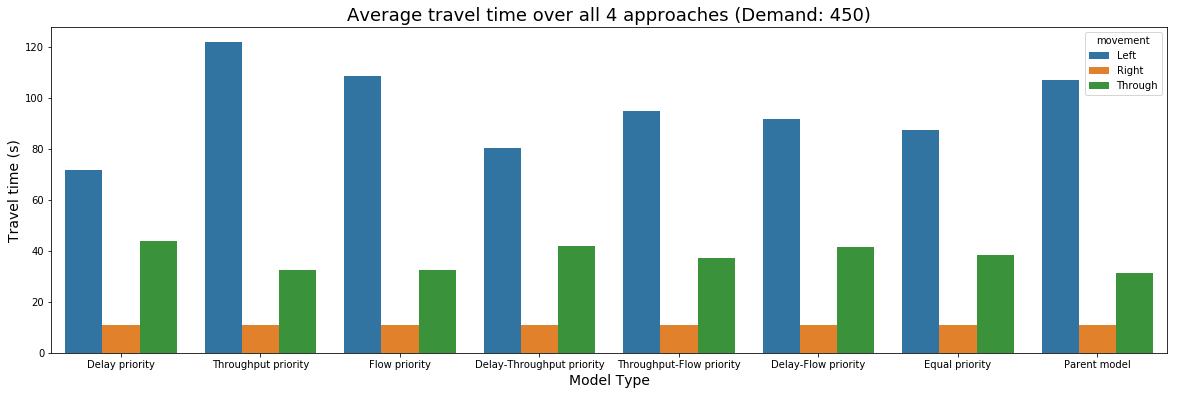

In [97]:
demand_tmp = 450

df_ave_traveltime_movements = df_ave_traveltime.groupby(['demand', 'model_type', 'movement']).agg({'travel_time': 'mean'}).reset_index()
df_ave_traveltime_movements = df_ave_traveltime_movements[df_ave_traveltime_movements['demand'] == demand_tmp]

fig, ax = plt.subplots(figsize=(20,6))

sns.barplot(data=df_ave_traveltime_movements, x='model_type', y='travel_time', hue='movement')

ax.set_title('Average travel time over all 4 approaches (Demand: {})'.format(demand_tmp), fontsize=18)
ax.set_xlabel('Model Type', fontsize=14)
ax.set_ylabel('Travel time (s)', fontsize=14)

### Average across movements (demand: 900)

Text(0,0.5,'Travel time (s)')

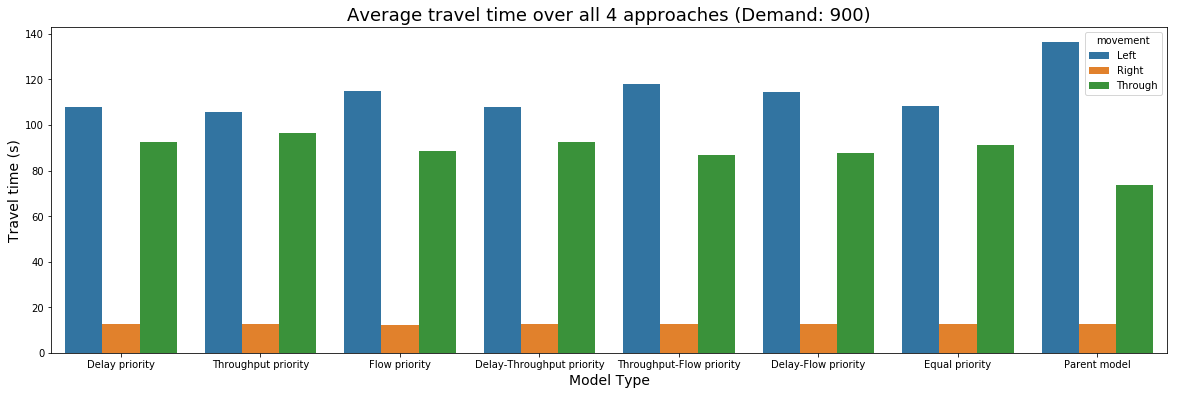

In [93]:
demand_tmp = 900

df_ave_traveltime_movements = df_ave_traveltime.groupby(['demand', 'model_type', 'movement']).agg({'travel_time': 'mean'}).reset_index()
df_ave_traveltime_movements = df_ave_traveltime_movements[df_ave_traveltime_movements['demand'] == demand_tmp]

fig, ax = plt.subplots(figsize=(20,6))

sns.barplot(data=df_ave_traveltime_movements, x='model_type', y='travel_time', hue='movement')

ax.set_title('Average travel time over all 4 approaches (Demand: {})'.format(demand_tmp), fontsize=18)
ax.set_xlabel('Model Type', fontsize=14)
ax.set_ylabel('Travel time (s)', fontsize=14)

### Comparison between approaches (demand: (450, 900))

Text(0.5,0,'')

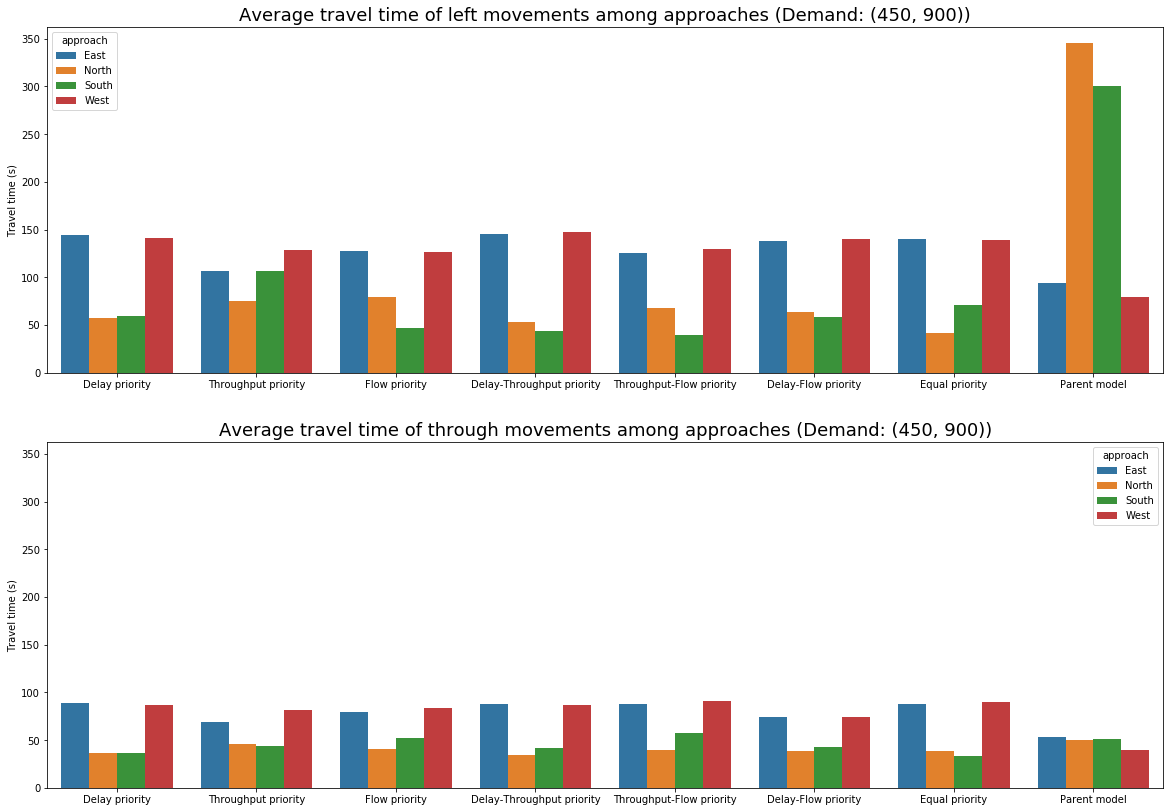

In [98]:
demand_tmp = (450, 900)

df_ave_traveltime_left = df_ave_traveltime[(df_ave_traveltime['demand'] == demand_tmp) & (df_ave_traveltime['movement'] == 'Left')]
df_ave_traveltime_thru = df_ave_traveltime[(df_ave_traveltime['demand'] == demand_tmp) & (df_ave_traveltime['movement'] == 'Through')]

fig, axs = plt.subplots(2,1,figsize=(20,14),sharey=True)

sns.barplot(data=df_ave_traveltime_left, x='model_type', y='travel_time', hue='approach', ax=axs[0])

axs[0].set_title('Average travel time of left movements among approaches (Demand: {})'.format(demand_tmp), fontsize=18)
axs[0].set_ylabel('Travel time (s)')
axs[0].set_xlabel('')

sns.barplot(data=df_ave_traveltime_thru, x='model_type', y='travel_time', hue='approach', ax=axs[1])

axs[1].set_title('Average travel time of through movements among approaches (Demand: {})'.format(demand_tmp), fontsize=18)
axs[1].set_ylabel('Travel time (s)')
axs[1].set_xlabel('')

### Comparison between approaches (demand: (900, 1800))

Text(0.5,0,'')

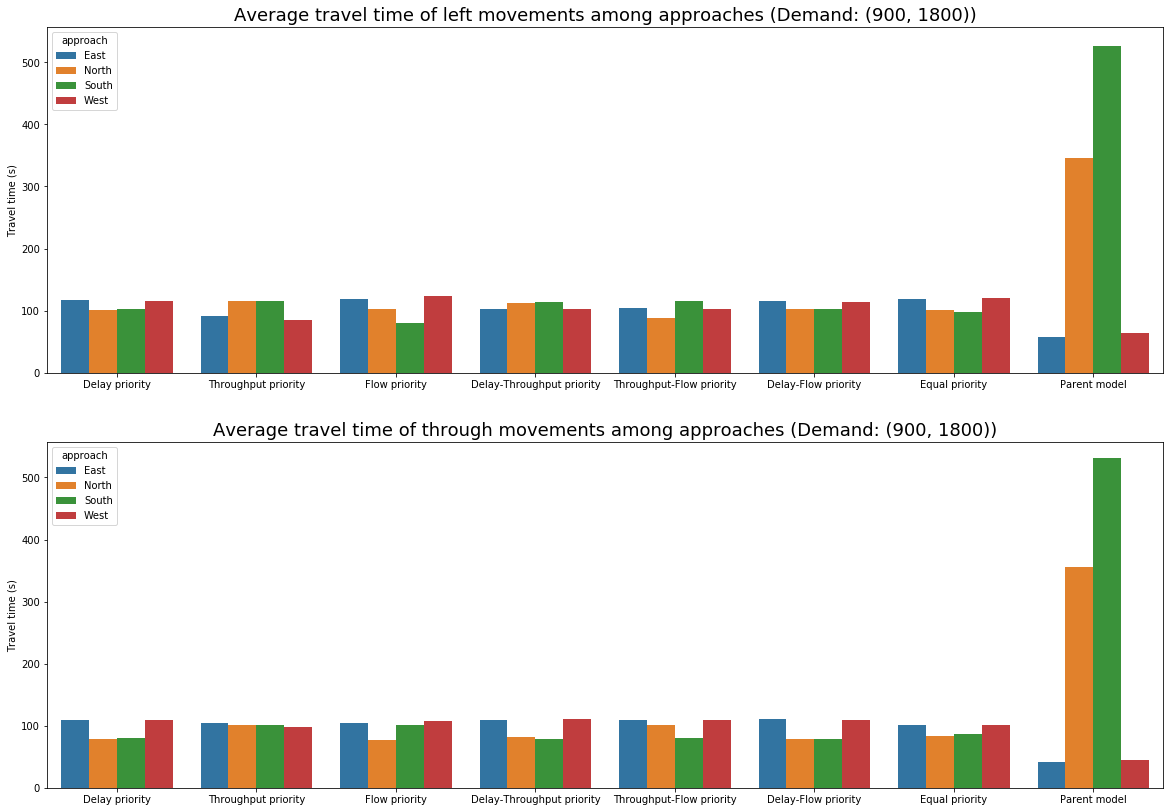

In [75]:
demand_tmp = (900, 1800)

df_ave_traveltime_left = df_ave_traveltime[(df_ave_traveltime['demand'] == demand_tmp) & (df_ave_traveltime['movement'] == 'Left')]
df_ave_traveltime_thru = df_ave_traveltime[(df_ave_traveltime['demand'] == demand_tmp) & (df_ave_traveltime['movement'] == 'Through')]

fig, axs = plt.subplots(2,1,figsize=(20,14),sharey=True)

sns.barplot(data=df_ave_traveltime_left, x='model_type', y='travel_time', hue='approach', ax=axs[0])

axs[0].set_title('Average travel time of left movements among approaches (Demand: {})'.format(demand_tmp), fontsize=18)
axs[0].set_ylabel('Travel time (s)')
axs[0].set_xlabel('')

sns.barplot(data=df_ave_traveltime_thru, x='model_type', y='travel_time', hue='approach', ax=axs[1])

axs[1].set_title('Average travel time of through movements among approaches (Demand: {})'.format(demand_tmp), fontsize=18)
axs[1].set_ylabel('Travel time (s)')
axs[1].set_xlabel('')

## Checking initial computation runtime in the 32 cases (seconds)

In [68]:
df_milp[df_milp.epoch == 0].pivot(index='demand', columns='model_type', values='runtime')[_model_type_cols].round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,165.90,268.79,573.48,475.49,293.79,540.86,752.90,370.31
900,5.30,284.86,617.50,6.77,292.91,8.85,10.81,200.26
"(450, 900)",40.05,104.16,151.78,48.29,134.06,51.76,86.14,87.43
"(900, 1800)",2.31,48.83,80.19,2.36,47.80,2.70,2.57,13.58


## Checking recomputation runtime in the 32 cases (average across epochs) (seconds)

In [69]:
df_milp[df_milp.epoch != 0].pivot_table(index='demand', columns='model_type', values='runtime', aggfunc='mean')[_model_type_cols].round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,2.06,0.74,0.52,1.96,0.70,2.11,2.05,79.22
900,1.89,0.61,0.43,1.80,0.89,1.84,1.79,82.21
"(450, 900)",1.99,0.63,0.48,1.95,0.72,2.06,2.04,84.12
"(900, 1800)",1.63,0.65,0.40,1.75,0.66,1.84,1.82,78.97


---

## Plot of cumulative delay (lower curve is better)

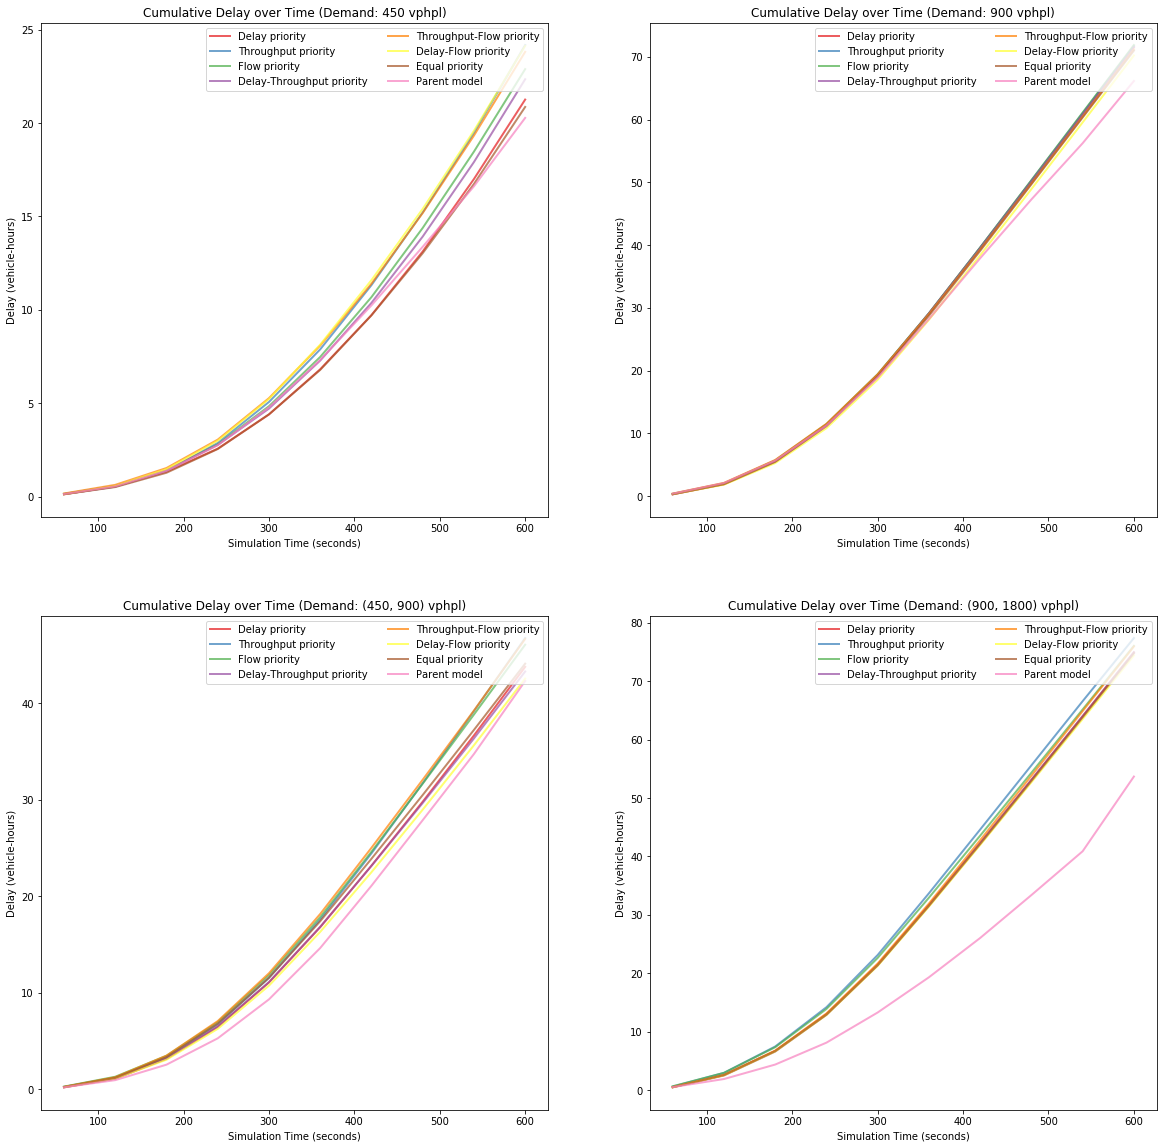

In [95]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumudelays = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-delays/delays_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumudelays[_model_type[weights]] = df_tmp.iloc[:, 4:].sum(axis=1).apply(lambda x: x / 3600)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumudelays:
        axs[ndx / 2, ndx % 2].plot(df_cumudelays.index, df_cumudelays[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Delay over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Delay (vehicle-hours)")

## Plot of cumulative throughput (higher is better)

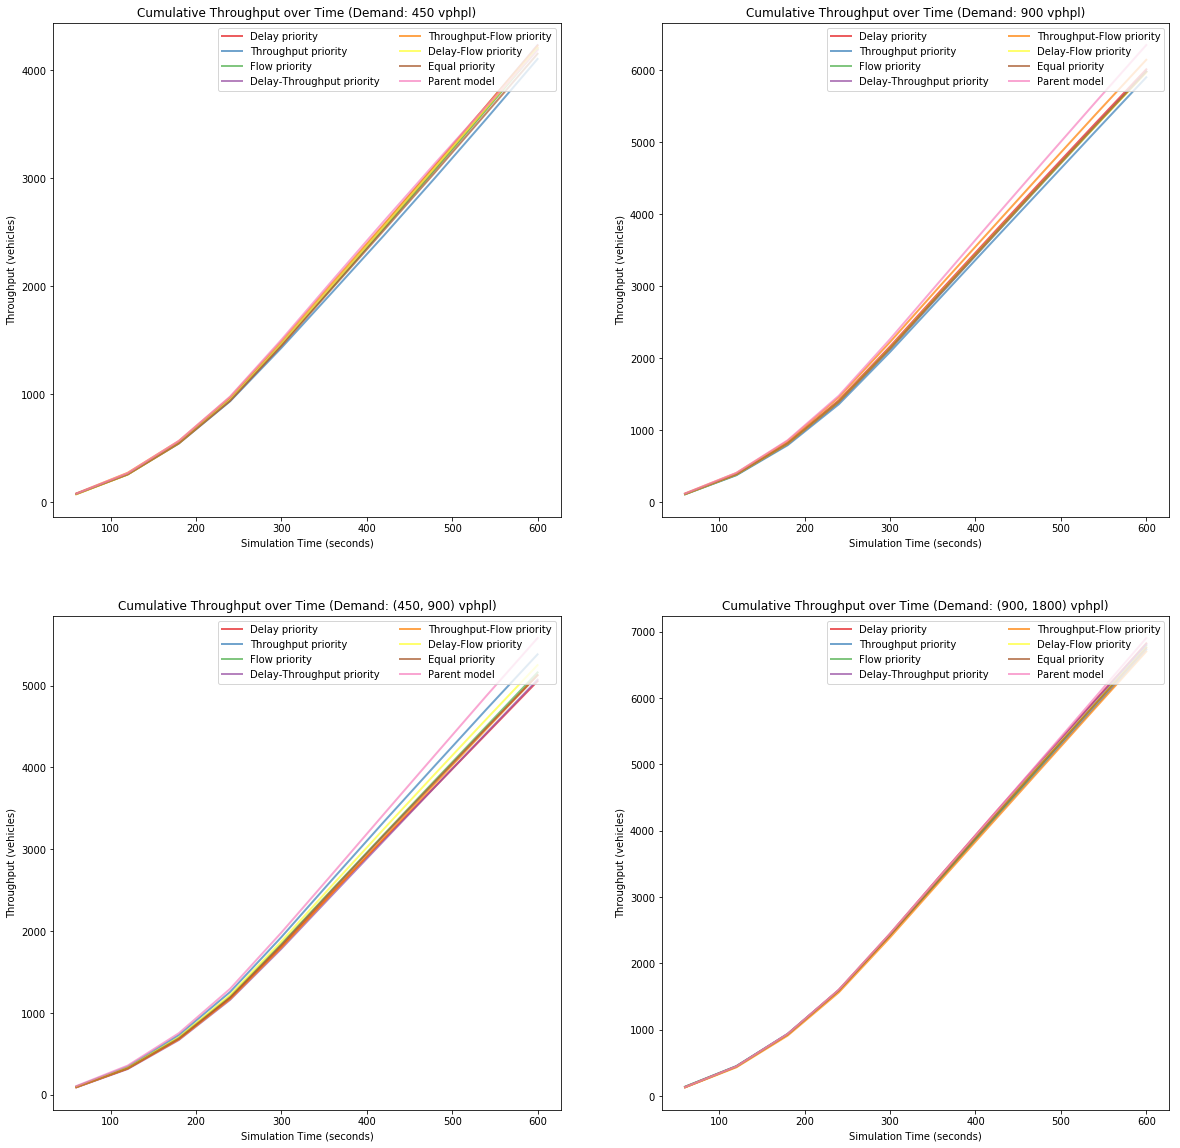

In [96]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumuthrus = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-thrus/thrus_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumuthrus[_model_type[weights]] = df_tmp.sum(axis=1)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumuthrus:
        axs[ndx / 2, ndx % 2].plot(df_cumuthrus.index, df_cumuthrus[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Throughput over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Throughput (vehicles)")